# Alignment & Operatrions

This notebook is more about *understanding* pandas, "going with the flow", than any particular method or operation.
Alignment is a key part of many parts of pandas, including

- binary operations (`+, -, *, /, **, ==, |, &`) between pandas objects
- merges / joins / concats
- constructors (`pd.DataFrame`, `pd.Series`)
- reindexing

That said, it's not really something you'll be doing explicitly.
It happens in the background, as part of all those tasks.
As far as I know, it's unique to pandas, so it may not click immediately.
It's all about pandas using *labels* (`Seies/DataFrame.index` and `DataFrame.columns`) to do the tricky work of making sure the operation goes through correctly.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display

In [8]:
%matplotlib inline

In [9]:
pd.options.display.max_rows = 10
sns.set(context='talk')
plt.style.use('default')

## Alignment without row labels (bad)

- separate datasets on GDP and CPI
- Goal: compute real GDP
- Problem: Different frequencies

I grabbed some data from [FRED](https://fred.stlouisfed.org/) on nominal US GDP (total output each quarter) and CPI (a measure of inflation).
Each CSV has a column of dates, and a column for the measurement.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>DATE</th>
      <th>CPIAUCSL</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1947-01-01</td>
      <td>21.48</td>
    </tr>
    <tr>
      <td>1947-02-01</td>
      <td>21.62</td>
    </tr>
    <tr>
      <td>1947-03-01</td>
      <td>22.00</td>
    </tr>
    <tr>
      <td>1947-04-01</td>
      <td>22.00</td>
    </tr>
    <tr>
      <td>1947-05-01</td>
      <td>21.95</td>
    </tr>
  </tbody>
</table>


Typically, we would use `DATE` as the index (`index_col='DATE'` in `read_csv`).
But to appreciate the value of labels, we'll take them away for now.
This will result in the default `range(n)` index.

In [10]:
# The "wrong" way
# Read in CPI & GDP, parsing the dates
gdp_bad = pd.read_csv("data/gdp.csv", parse_dates=['DATE'])
cpi_bad = pd.read_csv("data/cpi.csv", parse_dates=['DATE'])

In [11]:
gdp_bad.head()

,DATE,GDP
0,1947-01-01,243.1
1,1947-04-01,246.3
2,1947-07-01,250.1
3,1947-10-01,260.3
4,1948-01-01,266.2


In [12]:
cpi_bad.head()

,DATE,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


## Goal: Compute Real GDP

Our task is to calculate *real* GDP.
The data in the CSV is nominal GDP; it hasn't been adjusted for inflation.
To compute real GDP, you take nomial GDP (`gdp_bad`) and divide by a measure of inflation (`cpi_bad`).

- nomial GDP: Total output in dollars
- real GDP: Total output in constant dollars
- $\mathrm{real\ gdp} = \frac{\mathrm{nomial\ gdp}}{\mathrm{inflation}}$

Ideally, this would be as simple as `gdp_bad / cpi_bad`, but we have a slight issue: `gdp_bad` is measured quarterly, while `cpi_bad` is monthly.
The two need to be *aligned* before we can do the conversion from nominal to real GDP.

Normally, pandas would do this for us, but since we don't have meaningful row labels we have to do it manually.
We'll find the dates in common between the two series, manually filter to those, and then do the division.
You could do this a few ways; we'll go with a sql-style merge, roughly:

```SQL
select "DATE",
       GDP / CPIAUCSL as real_gdp
  from gdp_data
  join cpi_data using ("DATE")
```

In [13]:
# merge on DATE, divide
m = pd.merge(gdp_bad, cpi_bad, on='DATE', how='inner')
m.head()

,DATE,GDP,CPIAUCSL
0,1947-01-01,243.1,21.48
1,1947-04-01,246.3,22.00
2,1947-07-01,250.1,22.23
3,1947-10-01,260.3,22.91
4,1948-01-01,266.2,23.68


In [14]:
m['GDP'] / m['CPIAUCSL']

0      11.317505
1      11.195455
2      11.250562
3      11.361851
4      11.241554
         ...    
264    71.124715
265    71.343420
266    71.962930
267    72.711603
268    72.313495
Length: 269, dtype: float64

## Problems

1. The output has lost the `DATE` fields, we would need to manually bring those along after doing the division
2. We had to worry about doing the merge, which is incidental to the problem of calculating real gdp

## The Better Way

- Use row labels
- Specify `index_col='DATE'` in `read_csv`
- Just do the operation: `gdp / cpi`

When we have meaningful row labels shared across pandas objects, pandas will handle all the fiddly details for alignment for us.
Let's do things the proper way now, using `DATE` as our row labels.

We could use `gdp = gdp_bad.set_index("DATE")` to move a column into the index, but we'll just re-read the data from disk using the `index_col` method.

In [15]:
# use .squeeze to convert a 1 column df to a Series
gdp = pd.read_csv('data/gdp.csv', index_col='DATE',
                  parse_dates=['DATE']).squeeze()
gdp.head()

DATE
1947-01-01    243.1
1947-04-01    246.3
1947-07-01    250.1
1947-10-01    260.3
1948-01-01    266.2
Name: GDP, dtype: float64

In [16]:
cpi = pd.read_csv('data/cpi.csv', index_col='DATE',
                  parse_dates=['DATE']).squeeze()
cpi.head()

DATE
1947-01-01    21.48
1947-02-01    21.62
1947-03-01    22.00
1947-04-01    22.00
1947-05-01    21.95
Name: CPIAUCSL, dtype: float64

Now when you do the division, pandas will handle the alignemnt.

In [17]:
rgdp = gdp / cpi
rgdp

DATE
1947-01-01    11.317505
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.195455
1947-05-01          NaN
                ...    
2015-01-01          NaN
2015-02-01          NaN
2015-03-01          NaN
2015-04-01          NaN
2015-05-01          NaN
Length: 821, dtype: float64

You'll notice that a bunch of the values are `NaN`, short for ["Not A Number"](https://en.wikipedia.org/wiki/NaN).
This is the missing value indicator pandas uses for numeric data.
The `NaN`s are there because alignment produces the *union* of the two Indexes.

## Explicit Alignment

Roughly speaking, alignment composes two operations:

1. union the labels
2. reindex the data to conform to the unioned labels, inserting `NaN`s where necessary

In [18]:
# step 1: union indexes

full_idx = gdp.index.union(cpi.index)
full_idx

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01'],
              dtype='datetime64[ns]', name='DATE', length=821, freq=None)

In [19]:
# step 2: reindex
gdp.reindex(full_idx)

DATE
1947-01-01    243.1
1947-02-01      NaN
1947-03-01      NaN
1947-04-01    246.3
1947-05-01      NaN
              ...  
2015-01-01      NaN
2015-02-01      NaN
2015-03-01      NaN
2015-04-01      NaN
2015-05-01      NaN
Name: GDP, Length: 821, dtype: float64

Once the data have been reindexed, the operation (like `/` in our case) proceedes.

In [20]:
gdp.reindex(full_idx) / cpi.reindex(full_idx)

DATE
1947-01-01    11.317505
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.195455
1947-05-01          NaN
                ...    
2015-01-01          NaN
2015-02-01          NaN
2015-03-01          NaN
2015-04-01          NaN
2015-05-01          NaN
Length: 821, dtype: float64

Ocassionally, you will do a manual `reindex`, but most of the time it's done in the background when you do an operation.

<div class="alert alert-success" data-title="Compute Real GDP">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Compute Real GDP</h1>
</div>

<p>Compute real GDP in 2009 dollars</p>

You'll hear real GDP reported in '2009 dollars', or '2005 dollars'.
The deflator (CPI in our case) is an index, and doesn't really have units.
Some time span is chosen to be the base and set equal to 100.
Every other observation is relative to it.
The [data from FRED](https://fred.stlouisfed.org/series/CPIAUCSL) is indexed to 1982-1984.

For the exercise, compute real-gdp in 2009 dollars.

- Step 1: Convert CPI from base 1982-1984, to base 2009; Create a new series `cpi09` where the average value for 2009 is 100
    + Hint: Use [partial string indexing](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#datetimeindex-partial-string-indexing) to slice the values for just 2009
    + Divide the original `cpi` by that value and rescale to be an index (1 -> 100)
- Step 2: Divide `gdp` by the result from Step 1

In [ ]:
# Your solution
cpi09 = cpi / ... * 100
...

In [23]:
%load solutions/alignment_real_gdp09.py

DATE
1947-01-01    24.283366
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    24.021490
1947-05-01          NaN
                ...    
2015-01-01          NaN
2015-02-01          NaN
2015-03-01          NaN
2015-04-01          NaN
2015-05-01          NaN
Length: 821, dtype: float64

To the extent possible, you should use *meaningful labels*, rather than the default `range(n)` index.
This will put the burden of aligning things on pandas, rather than your memory.
Additionally, labels like the date are often "nuisance" columns, that would have to be dropped and recombined when doing arithmetic calculations.
When they're in the `.index`, they come along with the calculation but don't get in the way.

## Alignment on *both* axis

This may surpise you at some point down the road.

Above, we used the `.squeeze()` method to turn the 1-D `DataFrame` down to a `Series`.
We did this, because pandas will align on both the index *and* columns.
Can you guess what would happen if we divided two DataFrames, with different column names?

In [24]:
gdp_ = pd.read_csv('data/gdp.csv', index_col='DATE',
                   parse_dates=['DATE'])
gdp_.head()

,GDP
DATE,
1947-01-01,243.1
1947-04-01,246.3
1947-07-01,250.1
1947-10-01,260.3
1948-01-01,266.2


In [25]:
cpi_ = pd.read_csv('data/cpi.csv', index_col='DATE',
                   parse_dates=['DATE'])
cpi_.head()

,CPIAUCSL
DATE,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [26]:
gdp_ / cpi_

,CPIAUCSL,GDP
DATE,,
1947-01-01,NaN,NaN
1947-02-01,NaN,NaN
1947-03-01,NaN,NaN
1947-04-01,NaN,NaN
1947-05-01,NaN,NaN
...,...,...
2015-01-01,NaN,NaN
2015-02-01,NaN,NaN
2015-03-01,NaN,NaN


So pandas aligned by the columns, in addition to the index.
Recall that alignment does the set *union*, so the output DataFrame has both CPI and GDP, which probably isn't what we wanted here.

## Aside: Handling Missing Data

Pandas, recognizing that missing data is a fact of life, has a bunch of methods for detecting and handling missing data.

1. detecting missing data
2. dropping missing data
3. filling missing data

## Detecting Missing Data

1. `pd.isna(), df.isna()`
2. `pd.notna(), df.notna()`

In [30]:
# detect with `isna` and `notna`

rgdp.isna().head()

DATE
1947-01-01    False
1947-02-01     True
1947-03-01     True
1947-04-01    False
1947-05-01     True
dtype: bool

In [31]:
rgdp.notna().head()

DATE
1947-01-01     True
1947-02-01    False
1947-03-01    False
1947-04-01     True
1947-05-01    False
dtype: bool

These are often useful as masks for boolean indexing:

In [33]:
rgdp[rgdp.isna()].head()

DATE
1947-02-01   NaN
1947-03-01   NaN
1947-05-01   NaN
1947-06-01   NaN
1947-08-01   NaN
dtype: float64

Or for counting (True counts as 1, and False as 0 for numeric operations):

In [34]:
rgdp.isna().sum()

552

## Dropping Missing Data

You can drop missing values with `.dropna`

```
DataFrame.dropna

Return object with labels on given axis omitted where
alternately any or all of the data are missing

Parameters
----------
axis : {0 or 'index', 1 or 'columns'}, or tuple/list thereof
    Pass tuple or list to drop on multiple axes
how : {'any', 'all'}
    * any : if any NA values are present, drop that label
    * all : if all values are NA, drop that label
```

In [32]:
rgdp.dropna()

DATE
1947-01-01    11.317505
1947-04-01    11.195455
1947-07-01    11.250562
1947-10-01    11.361851
1948-01-01    11.241554
                ...    
2013-01-01    71.124715
2013-04-01    71.343420
2013-07-01    71.962930
2013-10-01    72.711603
2014-01-01    72.313495
Length: 269, dtype: float64

Almost all pandas methods return a new Series or DataFrame, and do not mutate data inplace.
`rgdp` still has the missing vaules, even though we called `.dropna`

In [33]:
rgdp.head()

DATE
1947-01-01    11.317505
1947-02-01          NaN
1947-03-01          NaN
1947-04-01    11.195455
1947-05-01          NaN
dtype: float64

To make the change stick, you can assign the output to a new variable (or re-assign it to `rgdp`) like `rgdp = rgdp.dropna()`.

## Dropna for DataFrames

Since `DataFrame` is a 2-d container, there are additional complexities with dropping missing data.
Do you drop the row or column? Does just one value in the row or column have to be missing, or all of them?

In [35]:
# We'll see concat later
df = pd.concat([gdp, cpi], axis='columns')
df.head()

,GDP,CPIAUCSL
DATE,,
1947-01-01,243.1,21.48
1947-02-01,NaN,21.62
1947-03-01,NaN,22.00
1947-04-01,246.3,22.00
1947-05-01,NaN,21.95


The defaults, shown next, are to drop *rows* (`axis='index'`) that
have at any missing values (`how='any'`):

In [36]:
df.dropna(axis='index', how='any')

,GDP,CPIAUCSL
DATE,,
1947-01-01,243.1,21.480
1947-04-01,246.3,22.000
1947-07-01,250.1,22.230
1947-10-01,260.3,22.910
1948-01-01,266.2,23.680
...,...,...
2013-01-01,16475.4,231.641
2013-04-01,16541.4,231.856
2013-07-01,16749.3,232.749


You can drop a row only if all of it's values are missing:

In [37]:
df.dropna(axis='index', how='all')

,GDP,CPIAUCSL
DATE,,
1947-01-01,243.1,21.480
1947-02-01,NaN,21.620
1947-03-01,NaN,22.000
1947-04-01,246.3,22.000
1947-05-01,NaN,21.950
...,...,...
2015-01-01,NaN,234.954
2015-02-01,NaN,235.415
2015-03-01,NaN,235.859


<div class="alert alert-success" data-title="Dropping Columns">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Dropping Columns</h1>
</div>
<p>Drop any `columns` in `df` that have at least one missing value</p>

In [39]:
%load solutions/dropna_columns.py

,CPIAUCSL
DATE,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2015-01-01,234.954
2015-02-01,235.415
2015-03-01,235.859


## Filling Missing Values

Use `.fillna` to fill with a value (scalar, or mapping of `label: value`) or method.

There's also `.fillna` to fill missing values, either with a value (which can be a scalar or array) or a method like `ffill` to fill-foward the last-observed value.

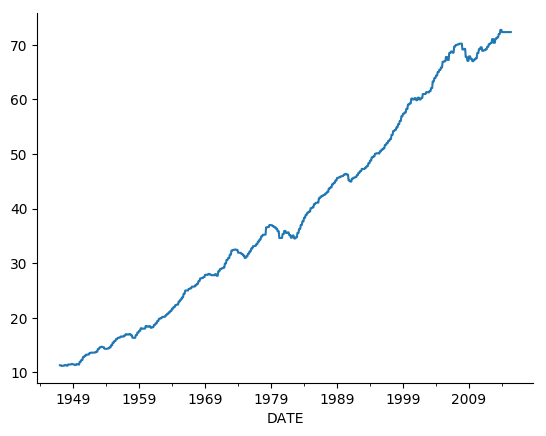

In [40]:
rgdp.fillna(method='ffill').plot()
sns.despine()

Missing data will come up throughout.

## Joining Pandas Objects

You have some options:

1. `pd.merge`: SQL-style joins
2. `pd.concat`: array-style joins

You'll run into problems where you have multiple `Series` or `DataFrame`s, that you want to join into a single `DataFrame`.
We saw an example of this earlier, but let's follow it up as a pair of exercises.

There are two main ways to do this, `pd.merge` and `pd.concat`.

When to use `merge` vs. `concat`?
My general rule is to use `concat` for one-to-one joins of two or more Series/DataFrames, where your joining on the index.
I use `pd.merge` when doing database style joins that are one-to-many, or many-to-many, or whenever you're joining on a column.

<div class="alert alert-success" data-title="Merge Datasets">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Merge Datasets</h1>
</div>

<p>
Use [`pd.merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.merge.html) to join the two DataFrames `gdp_bad` and `cpi_bad`, using an *outer* join (earlier we used an *inner* join).
</p>

- Hint: You may want to sort by date afterward (see [`DataFrame.sort_values`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html))

In [41]:
# Your solution


In [43]:
%load solutions/aligment_merge.py

,DATE,GDP,CPIAUCSL
0,1947-01-01,243.1,21.48
269,1947-02-01,NaN,21.62
270,1947-03-01,NaN,22.00
1,1947-04-01,246.3,22.00
271,1947-05-01,NaN,21.95


<div class="alert alert-success" data-title="Concatenate Datasets">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Concatenate Datasets</h1>
</div>

<p>
Use [`pd.concat`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html) to stick together `gdp` and `cpi` into a DataFrame</p>

- Hint: what should the argument to `axis` be?

In [36]:
# Your solution


In [45]:
%load solutions/aligment_concat.py

,GDP,CPIAUCSL
DATE,,
1947-01-01,243.1,21.48
1947-02-01,NaN,21.62
1947-03-01,NaN,22.00
1947-04-01,246.3,22.00
1947-05-01,NaN,21.95


## ufuncs And Reductions

These next couple of topics aren't really related to alignment, but I didn't have anywhere else to put them.

NumPy has the concept of [universal functions](https://docs.scipy.org/doc/numpy/reference/ufuncs.html) (ufuncs) that operate on any sized array.

In [46]:
np.log(df)

,GDP,CPIAUCSL
DATE,,
1947-01-01,5.493473,3.067122
1947-02-01,NaN,3.073619
1947-03-01,NaN,3.091042
1947-04-01,5.506550,3.091042
1947-05-01,NaN,3.088767
...,...,...
2015-01-01,NaN,5.459390
2015-02-01,NaN,5.461350
2015-03-01,NaN,5.463234


`ufuncs` work elementwise, which means they don't care about the dimensions, just the data types.
Even something like adding a scalar is a ufunc. 

In [47]:
df + 100

,GDP,CPIAUCSL
DATE,,
1947-01-01,343.1,121.480
1947-02-01,NaN,121.620
1947-03-01,NaN,122.000
1947-04-01,346.3,122.000
1947-05-01,NaN,121.950
...,...,...
2015-01-01,NaN,334.954
2015-02-01,NaN,335.415
2015-03-01,NaN,335.859


## Reductions

`DataFrame` has many methods that *reduce* a DataFrame to a Series by aggregating over a dimension.
Likewise, `Series` has many methods that collapse down to a scalar.
Some examples are `.mean`, `.std`, `.max`, `.any`, `.all`.

Let's get a DataFrame with two columns on a similar scale.
The `pct_change` method returns the `(current - previous) / previous` for each row (with `NaN` for the first since there isn't a previous.

In [48]:
pct_change = df.dropna().pct_change()
pct_change.head()

,GDP,CPIAUCSL
DATE,,
1947-01-01,NaN,NaN
1947-04-01,0.013163,0.024209
1947-07-01,0.015428,0.010455
1947-10-01,0.040784,0.030589
1948-01-01,0.022666,0.033610


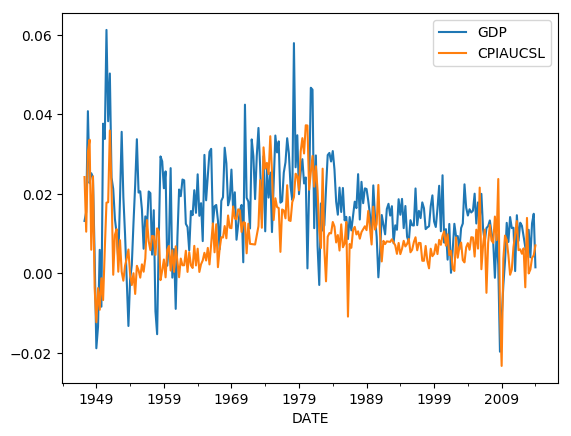

In [49]:
pct_change.plot();

By default, the index (0) axis is reduced for `DataFrames`.

In [50]:
pct_change.mean()

GDP         0.016044
CPIAUCSL    0.009012
dtype: float64

To collapse the columns (leaving the same row labels), use the `axis` argument.
Specifying `axis='columns'` or `axis=1` will aggregate over the columns

In [51]:
pct_change.max(axis='columns')

DATE
1947-01-01         NaN
1947-04-01    0.024209
1947-07-01    0.015428
1947-10-01    0.040784
1948-01-01    0.033610
                ...   
2013-01-01    0.010928
2013-04-01    0.004006
2013-07-01    0.012568
2013-10-01    0.014962
2014-01-01    0.007002
Freq: 3MS, Length: 269, dtype: float64

If you have trouble remembering, the `axis` argument specifies the axis you want to *remove*.

In [52]:
# Which column had the larger percent change?
pct_change.idxmax(axis="columns")

DATE
1947-01-01         NaN
1947-04-01    CPIAUCSL
1947-07-01         GDP
1947-10-01         GDP
1948-01-01    CPIAUCSL
                ...   
2013-01-01         GDP
2013-04-01         GDP
2013-07-01         GDP
2013-10-01         GDP
2014-01-01    CPIAUCSL
Freq: 3MS, Length: 269, dtype: object

<div class="alert alert-success" data-title="Percent Positive">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Percent Positive</h1>
</div>


<p>Exercise: What percent of the periods had a positive percent change for each column?</p>

In [54]:
%load solutions/alignment_positive.py

GDP         0.936803
CPIAUCSL    0.907063
dtype: float64

## Summary

- Auto-alignment in pandas is different than most other systems
- Let pandas handle the details of alignment, you worry about important things
- Pandas methods are non-mutating
- `.dropna`, `.filla`, `isna` for handling missing data